In [12]:
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [13]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt

class OptimizedBSpline(nn.Module):
    """Optimized B-spline with iterative De Boor algorithm"""
    def __init__(self, knots, degree=3):
        super().__init__()
        self.knots = knots
        self.degree = degree
        self.n_knots = len(knots)

    def _find_interval(self, t):
        t_clamped = torch.clamp(t, self.knots[self.degree], self.knots[self.n_knots - self.degree - 1])
        i = torch.searchsorted(self.knots, t_clamped, right=True) - 1
        return torch.clamp(i, self.degree, self.n_knots - self.degree - 1)

    def forward(self, t, control_points):
        batch_size = t.shape[0]
        n_control = len(control_points)
        k = self.degree
        interval = self._find_interval(t)
        d = torch.zeros(batch_size, k + 1, device=t.device, dtype=t.dtype)
        for j in range(k + 1):
            idx = torch.clamp(interval - k + j, 0, n_control - 1)
            d[:, j] = control_points[idx]
        for r in range(1, k + 1):
            for j in range(k, r - 1, -1):
                left_knot = self.knots[interval - k + j]
                right_knot = self.knots[interval - k + j + r]
                alpha = (t - left_knot) / (right_knot - left_knot + 1e-8)
                d[:, j] = (1 - alpha) * d[:, j - 1] + alpha * d[:, j]
        return d[:, k]

class OptimizedTorchCubicSpline(nn.Module):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = nn.Parameter(y)
        n = len(x)
        self.register_buffer('knots', torch.cat([x[0].repeat(3), x[1:-1], x[-1].repeat(3)]))
        self.bspline = OptimizedBSpline(self.knots, degree=3)
        self.x_min = x[0]
        self.x_max = x[-1]

    def forward(self, t):
        return self.bspline(torch.clamp(t, self.x_min, self.x_max), self.y)

class OptimizedDifferentiablePchip(nn.Module):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = nn.Parameter(y)
        self.n = len(x) - 1

    def _compute_derivatives(self, y):
        dy = y[1:] - y[:-1]
        dx = self.x[1:] - self.x[:-1]
        slopes = dy / dx
        d = torch.zeros_like(y)
        for i in range(1, len(y)-1):
            if slopes[i-1] * slopes[i] > 0:
                w1 = 2*dx[i] + dx[i-1]
                w2 = dx[i] + 2*dx[i-1]
                d[i] = (w1 + w2) / (w1/slopes[i-1] + w2/slopes[i])
        d[0] = slopes[0]
        d[-1] = slopes[-1]
        return d

    def forward(self, t):
        t = t.contiguous()
        idx = torch.clamp(torch.searchsorted(self.x, t) - 1, 0, self.n - 1)
        x0 = self.x[idx]
        x1 = self.x[idx + 1]
        y0 = self.y[idx]
        y1 = self.y[idx + 1]
        t_norm = (t - x0) / (x1 - x0)
        d = self._compute_derivatives(self.y)
        d0 = d[idx]
        d1 = d[idx + 1]
        t2 = t_norm * t_norm
        t3 = t2 * t_norm
        h00 = 2*t3 - 3*t2 + 1
        h10 = t3 - 2*t2 + t_norm
        h01 = -2*t3 + 3*t2
        h11 = t3 - t2
        dx_segment = x1 - x0
        return h00 * y0 + h10 * dx_segment * d0 + h01 * y1 + h11 * dx_segment * d1

class OptimizedPyTorchGradientSMPA(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.05, epochs=200, random_state=7, verbose=False,
                 lambda_reg=0.0001, patience=10, decay_factor=0.9, min_learning_rate=1e-6,
                 n_control_points=6, smoothing_factor=0.0001, spline_type='cubic',
                 device=None, track_history=False, optimizer_type='adam',
                 scheduler_type='reduce_on_plateau', weight_reg=0.001, weight_l1=1e-5):
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_reg = lambda_reg
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.smoothing_factor = smoothing_factor
        self.spline_type = spline_type
        self.device = device if device is not None else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.track_history = track_history
        self.optimizer_type = optimizer_type
        self.scheduler_type = scheduler_type
        self.weight_reg = weight_reg
        self.weight_l1 = weight_l1
        if spline_type not in ['cubic', 'pchip']:
            raise ValueError("spline_type must be 'cubic' or 'pchip'")
        torch.manual_seed(random_state)
        np.random.seed(random_state)

    def _to_tensor(self, data, dtype=torch.float32):
        if isinstance(data, torch.Tensor):
            return data.to(self.device, dtype=dtype, non_blocking=True)
        return torch.tensor(data, dtype=dtype, device=self.device)

    def _calculate_class_means(self, X, y):
        mask_1 = y == 1
        self.m1 = torch.mean(X[mask_1], dim=0)
        self.m0 = torch.mean(X[~mask_1], dim=0)

    def _initialize_control_points(self, X):
        n_features = X.shape[1] - 1
        self.spline_models = nn.ModuleList()
        self.feature_scales = [X[:, i].abs().max().item() + 1e-8 for i in range(n_features)]
        for i in range(n_features):
            x_min, x_max = X[:, i].min().item(), X[:, i].max().item()
            control_x = torch.linspace(x_min, x_max, self.n_control_points, device=self.device)
            y_min, y_max = X[:, -1].min().item(), X[:, -1].max().item()
            y_mid = (self.m0[-1] + self.m1[-1]) / 2
            y_range = y_max - y_min
            control_y = torch.empty(self.n_control_points, device=self.device).uniform_(
                y_mid - y_range * 0.5, y_mid + y_range * 0.5
            )
            if self.spline_type == 'cubic':
                spline = OptimizedTorchCubicSpline(control_x, control_y).to(self.device)
            else:
                spline = OptimizedDifferentiablePchip(control_x, control_y).to(self.device)
            self.spline_models.append(spline)
        self.weights = nn.Parameter(torch.full((n_features,), 0.5, device=self.device))
        self.initial_control_points = [(m.x.clone(), m.y.clone()) for m in self.spline_models]

    def _calculate_displacement(self, X):
        product = torch.ones(X.shape[0], device=X.device, dtype=X.dtype)
        for i, (w, spline) in enumerate(zip(self.weights, self.spline_models)):
            spline_output = spline(X[:, i])
            normalized_output = spline_output / self.feature_scales[i]
            product *= (1 + w * normalized_output)
        return X[:, -1] - product

    def _update_pseudo_labels(self, X, y):
        m1_displacement = self._calculate_displacement(self.m1.unsqueeze(0))[0]
        self.class_1_pseudo = 1 if m1_displacement > 0 else -1
        self.class_0_pseudo = -self.class_1_pseudo
        return torch.where(y == 1, self.class_1_pseudo, self.class_0_pseudo)

    def _create_optimizer_and_scheduler(self):
        params = [p for spline in self.spline_models for p in spline.parameters()] + [self.weights]
        if self.optimizer_type.lower() == 'adam':
            optimizer = torch.optim.Adam(params, lr=self.initial_learning_rate)
        else:
            optimizer = torch.optim.SGD(params, lr=self.initial_learning_rate)
        if self.scheduler_type.lower() == 'reduce_on_plateau':
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=self.decay_factor,
                patience=self.patience, min_lr=self.min_learning_rate)
        else:
            scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer, step_size=self.patience, gamma=self.decay_factor
            )
        return optimizer, scheduler

    def fit(self, X, y):
        try:
            l = np.unique(y)
            if len(l) != 2:
                raise ValueError("Algorithm for binary classification only.")
            if X.shape[1] < 2:
                raise ValueError("At least 2 features required")

            self.label_mapping = {l[0]: 0, l[1]: 1}
            y = np.where(y == l[0], 0, 1)

            X_tensor = self._to_tensor(X)
            y_tensor = self._to_tensor(y, dtype=torch.long)

            with torch.no_grad():
                self._calculate_class_means(X_tensor, y_tensor)
                self._initialize_control_points(X_tensor)

            optimizer, scheduler = self._create_optimizer_and_scheduler()

            best_error = float('inf')
            best_control_ys = [spline.y.clone() for spline in self.spline_models]
            best_weights = self.weights.clone()
            best_class_1_pseudo = None

            if self.track_history:
                self.error_history_ = []
                self.control_point_history = [self.initial_control_points]

            for epoch in range(self.epochs):
                pseudo_labels = self._update_pseudo_labels(X_tensor, y_tensor)
                displacements = self._calculate_displacement(X_tensor)

                errors = displacements * pseudo_labels <= 0
                error_count = errors.sum().item()

                if self.verbose and epoch % 5 == 0:
                    current_lr = optimizer.param_groups[0]['lr']
                    product = torch.ones(X_tensor.shape[0], device=X_tensor.device)
                    for i, (w, spline) in enumerate(zip(self.weights, self.spline_models)):
                        spline_output = spline(X_tensor[:, i])
                        normalized_output = spline_output / self.feature_scales[i]
                        product *= (1 + w * normalized_output)
                    print(f"Epoch {epoch}: Errors = {error_count}, LR = {current_lr:.6f}")
                    print(f"  Mean product: {product.mean().item():.4f}, "
                          f"Mean displacement: {displacements.mean().item():.4f}, "
                          f"Weights mean: {self.weights.mean().item():.4f}, "
                          f"Weights std: {self.weights.std().item():.4f}")

                if error_count < best_error:
                    best_error = error_count
                    best_control_ys = [spline.y.clone() for spline in self.spline_models]
                    best_weights = self.weights.clone()
                    best_class_1_pseudo = self.class_1_pseudo
                    self.best_epoch = epoch
                    if error_count == 0 and epoch > 10:
                        if self.verbose:
                            print(f"Perfect separation achieved at epoch {epoch}")
                        break

                if self.track_history:
                    self.error_history_.append(error_count)
                    self.control_point_history.append(
                        [(s.x.clone().cpu().numpy(), s.y.clone().detach().cpu().numpy())
                         for s in self.spline_models]
                    )

                if error_count == 0:
                    continue

                error_indices = torch.where(errors)[0]
                if len(error_indices) == 0:
                    continue
                X_err = X_tensor[error_indices]
                y_err = y_tensor[error_indices]
                ti = torch.where(y_err == 1, 1, -1)

                product = torch.ones(X_err.shape[0], device=X_err.device, dtype=X_err.dtype)
                for i, (w, spline) in enumerate(zip(self.weights, self.spline_models)):
                    spline_output = spline(X_err[:, i])
                    normalized_output = spline_output / self.feature_scales[i]
                    product *= (1 + w * normalized_output)
                loss = torch.mean(torch.relu(1.0 - ti * self.class_1_pseudo * (X_err[:, -1] - product)))

                if self.lambda_reg > 0:
                    smoothness_penalty = 0
                    for spline in self.spline_models:
                        y_diff = spline.y[1:] - spline.y[:-1]
                        x_diff = spline.x[1:] - spline.x[:-1]
                        smoothness_penalty += torch.mean((y_diff / (x_diff + 1e-8))**2)
                    loss += self.lambda_reg * smoothness_penalty
                if self.weight_reg > 0:
                    weight_penalty = torch.sum(self.weights ** 2)
                    loss += self.weight_reg * weight_penalty
                if self.weight_l1 > 0:
                    weight_l1_penalty = torch.sum(torch.abs(self.weights))
                    loss += self.weight_l1 * weight_l1_penalty

                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    [p for spline in self.spline_models for p in spline.parameters()] + [self.weights],
                    max_norm=10.0
                )
                if epoch % 5 == 0 and self.verbose:
                    for i, spline in enumerate(self.spline_models[:3]):  # Limit to 3 for brevity
                        grad_norm = torch.norm(spline.y.grad) if spline.y.grad is not None else 0
                        print(f"  Spline {i} grad norm: {grad_norm:.4f}")
                    print(f"  Weights grad norm: {torch.norm(self.weights.grad):.4f}")
                optimizer.step()

                if scheduler is not None:
                    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                        scheduler.step(error_count)
                    else:
                        scheduler.step()
                    if optimizer.param_groups[0]['lr'] <= self.min_learning_rate:
                        if self.verbose:
                            print(f"Minimum learning rate reached at epoch {epoch}")
                        break

            for spline, best_y in zip(self.spline_models, best_control_ys):
                spline.y.data = best_y
            self.weights.data = best_weights
            self.class_1_pseudo = best_class_1_pseudo
        except Exception as e:
            print(f"Error in SMPA fit: {str(e)}")
            import traceback
            traceback.print_exc()
            raise
        return self

    def predict(self, X):
        X_tensor = self._to_tensor(X)
        displacements = self._calculate_displacement(X_tensor)
        predictions = torch.where(displacements > 0,
                                torch.tensor(1 if self.class_1_pseudo > 0 else 0, device=self.device),
                                torch.tensor(0 if self.class_1_pseudo > 0 else 1, device=self.device))
        pred_numpy = predictions.cpu().numpy()
        reverse_mapping = {v: k for k, v in self.label_mapping.items()}
        original_predictions = np.array([reverse_mapping[p] for p in pred_numpy])
        return original_predictions

    def predict_proba(self, X):
        X_tensor = self._to_tensor(X)
        displacements = self._calculate_displacement(X_tensor)
        raw_probs = 1 / (1 + torch.exp(-displacements * self.class_1_pseudo * 0.5))
        if self.class_1_pseudo > 0:
            probs = torch.column_stack([1 - raw_probs, raw_probs])
        else:
            probs = torch.column_stack([raw_probs, 1 - raw_probs])
        return probs.cpu().detach().numpy()

    def plot_convergence(self, figsize=(10, 4)):
        if not self.track_history or not hasattr(self, 'error_history_'):
            print("Convergence plotting requires track_history=True and a fitted model.")
            return None
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(self.error_history_, 'b-', label='Errors')
        ax.set_title('Error Convergence')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Number of Errors')
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        return fig

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
import numpy as np

def generate_toy_dataset(n_samples=1000, random_state=7):
    # Set random seed for reproducibility
    np.random.seed(random_state)

    # Generate 3 predictive features
    x1 = np.random.uniform(-1, 1, n_samples)
    x2 = np.random.uniform(-1, 1, n_samples)
    x3 = np.random.uniform(-1, 1, n_samples)

    # Compute response variable with interactions and non-linearity
    X_last = x1 * x2 + np.sin(np.pi * x3) + np.random.normal(0, 0.1, n_samples)

    # Combine into feature matrix (x1, x2, x3, X_last)
    X = np.column_stack([x1, x2, x3, X_last])

    # Generate labels based on X_last threshold (median for balanced classes)
    threshold = np.median(X_last)
    y = (X_last > threshold).astype(int)

    return X, y

# Generate dataset
X, y = generate_toy_dataset(n_samples=1000, random_state=7)

# Verify dataset
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Class balance:", np.bincount(y))
print("X[:, -1] range:", X[:, -1].min(), X[:, -1].max())
print("Feature ranges:", X[:, :-1].min(axis=0), X[:, :-1].max(axis=0))

X shape: (1000, 4)
y shape: (1000,)
Class balance: [500 500]
X[:, -1] range: -1.9276860663104305 1.9406380647122043
Feature ranges: [-0.99963016 -0.99710631 -0.99588175] [0.99946603 0.99601529 0.9995589 ]


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=21)

In [17]:
def reorder_least_correlated_feature(X, standardize=True, feature_order=None, scaler=None, valid_mask=None):
    X_np = np.asarray(X)
    if valid_mask is None:  # Train: compute mask
        variances = np.var(X_np, axis=0)
        valid_mask = variances > 0
        print(f"Train: Filtered {np.sum(~valid_mask)} zero-variance features")
    X_np = X_np[:, valid_mask]  # Apply mask to both train and test

    if feature_order is None:  # Train
        if standardize:
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_np)
        else:
            X_scaled = X_np.copy()
        corr_matrix = np.abs(np.corrcoef(X_scaled, rowvar=False))
        n_features = X_scaled.shape[1]
        avg_corr = (np.sum(corr_matrix, axis=1) - np.diag(corr_matrix)) / (n_features - 1)
        target_idx = np.argmin(avg_corr)
        feature_order = list(range(n_features))
        feature_order.pop(target_idx)
        feature_order.append(target_idx)
        X_reordered = X_scaled[:, feature_order]
    else:  # Test
        if standardize and scaler is not None:
            X_scaled = scaler.transform(X_np)  # Now same # of features
            X_reordered = X_scaled[:, feature_order]
        else:
            X_reordered = X_np[:, feature_order]
    return X_reordered, feature_order, scaler, valid_mask

# Apply with consistent mask
X_train_reordered, feature_order, scaler, valid_mask = reorder_least_correlated_feature(X_train, standardize=True)
X_test_reordered, _, _, _ = reorder_least_correlated_feature(X_test, standardize=True, feature_order=feature_order, scaler=scaler, valid_mask=valid_mask)

Train: Filtered 0 zero-variance features


In [18]:


# Initialize and fit model
model = OptimizedPyTorchGradientSMPA(
    learning_rate=0.01, epochs=250, random_state=7, verbose=True,
    spline_type='pchip', track_history=True, lambda_reg=0.0001, weight_reg=0.001
)
model.fit(X_train_reordered, y_train)

Epoch 0: Errors = 346, LR = 0.010000
  Mean product: 0.9929, Mean displacement: -0.9929, Weights mean: 0.5000, Weights std: 0.0000
  Spline 0 grad norm: 0.0676
  Spline 1 grad norm: 0.1131
  Spline 2 grad norm: 0.1064
  Weights grad norm: 0.1706
Epoch 5: Errors = 338, LR = 0.010000
  Mean product: 0.9761, Mean displacement: -0.9761, Weights mean: 0.5501, Weights std: 0.0000
  Spline 0 grad norm: 0.0730
  Spline 1 grad norm: 0.1195
  Spline 2 grad norm: 0.1136
  Weights grad norm: 0.1867
Epoch 10: Errors = 324, LR = 0.010000
  Mean product: 0.9550, Mean displacement: -0.9550, Weights mean: 0.6007, Weights std: 0.0003
  Spline 0 grad norm: 0.0735
  Spline 1 grad norm: 0.1223
  Spline 2 grad norm: 0.1180
  Weights grad norm: 0.1986
Epoch 15: Errors = 321, LR = 0.010000
  Mean product: 0.9293, Mean displacement: -0.9293, Weights mean: 0.6517, Weights std: 0.0012
  Spline 0 grad norm: 0.0703
  Spline 1 grad norm: 0.1229
  Spline 2 grad norm: 0.1362
  Weights grad norm: 0.2077
Epoch 20: Erro

OptimizedPyTorchGradientSMPA(device='cpu', epochs=250, learning_rate=0.01,
                             spline_type='pchip', track_history=True,
                             verbose=True)

Train Accuracy: 0.9962
Test Accuracy: 0.9950


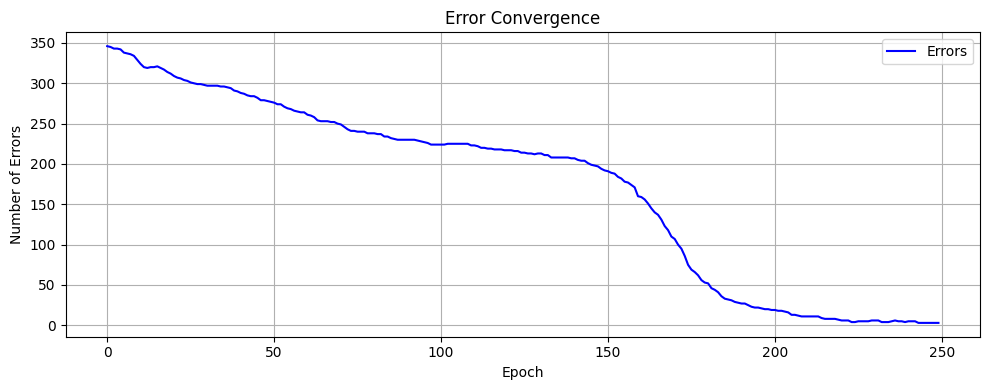

In [19]:
# Evaluate
train_predictions = model.predict(X_train_reordered)
accuracy = np.mean(train_predictions == y_train)
print(f"Train Accuracy: {accuracy:.4f}")



predictions = model.predict(X_test_reordered)
accuracy = np.mean(predictions == y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Plot convergence
fig = model.plot_convergence()
plt.show()

In [20]:
from sklearn.svm import SVC

svm = SVC(C = 1.0, kernel='rbf')

svm.fit(X_train_reordered, y_train)
print(svm.score(X_train_reordered, y_train))

print(svm.score(X_test_reordered, y_test))

0.9775
0.98


In [21]:
import torch
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import time

In [22]:
# Load MNIST
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Extract NumPy arrays
X_train = train_dataset.data.numpy()  # Shape: (60000, 28, 28)
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy()    # Shape: (10000, 28, 28)
y_test = test_dataset.targets.numpy()

# Filter for binary classes (e.g., 0 vs 1)
train_mask = (y_train == 8) | (y_train == 9)
test_mask = (y_test == 8) | (y_test == 9)
X_train_bin = X_train[train_mask].reshape(-1, 28*28)
y_train_bin_orig = y_train[train_mask]
X_test_bin = X_test[test_mask].reshape(-1, 28*28)
y_test_bin_orig = y_test[test_mask]

# Shuffle training data
rng = np.random.RandomState(12)  # For reproducibility
shuffle_idx = rng.permutation(len(X_train_bin))
X_train_bin = X_train_bin[shuffle_idx]
y_train_bin_orig = y_train_bin_orig[shuffle_idx]  # Shuffle the original labels

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class OptimizedBSpline(nn.Module):
    """Optimized B-spline with iterative De Boor algorithm"""
    def __init__(self, knots, degree=3):
        super().__init__()
        self.knots = knots
        self.degree = degree
        self.n_knots = len(knots)

    def _find_interval(self, t):
        """Find the knot interval index for each t value"""
        # Clamp t to valid range and find interval using searchsorted
        t_clamped = torch.clamp(t, self.knots[self.degree], self.knots[self.n_knots - self.degree - 1])
        i = torch.searchsorted(self.knots, t_clamped, right=True) - 1
        # Ensure i stays within valid bounds for degree-k spline
        return torch.clamp(i, self.degree, self.n_knots - self.degree - 1)

    def forward(self, t, control_points):
        """Iterative De Boor algorithm for B-spline evaluation"""
        batch_size = t.shape[0]
        n_control = len(control_points)
        k = self.degree

        # Find knot interval for each t
        interval = self._find_interval(t)  # Shape: [batch_size]

        # Initialize temporary control points for each t
        d = torch.zeros(batch_size, k + 1, device=t.device, dtype=t.dtype)
        for j in range(k + 1):
            idx = torch.clamp(interval - k + j, 0, n_control - 1)
            d[:, j] = control_points[idx]

        # Iterative De Boor computation
        for r in range(1, k + 1):
            for j in range(k, r - 1, -1):
                left_knot = self.knots[interval - k + j]
                right_knot = self.knots[interval - k + j + r]
                alpha = (t - left_knot) / (right_knot - left_knot + 1e-8)  # Add epsilon for stability
                d[:, j] = (1 - alpha) * d[:, j - 1] + alpha * d[:, j]

        return d[:, k]  # Final value for each t

class OptimizedTorchCubicSpline(nn.Module):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = nn.Parameter(y)
        n = len(x)
        self.register_buffer('knots', torch.cat([x[0].repeat(3), x[1:-1], x[-1].repeat(3)]))
        self.bspline = OptimizedBSpline(self.knots, degree=3)
        self.x_min = x[0]
        self.x_max = x[-1]

    def forward(self, t):
        return self.bspline(torch.clamp(t, self.x_min, self.x_max), self.y)

class OptimizedDifferentiablePchip(nn.Module):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = nn.Parameter(y)
        self.n = len(x) - 1

    def _compute_derivatives(self, y):
        dy = y[1:] - y[:-1]
        dx = self.x[1:] - self.x[:-1]
        slopes = dy / dx
        d = torch.zeros_like(y)
        for i in range(1, len(y)-1):
            if slopes[i-1] * slopes[i] > 0:
                w1 = 2*dx[i] + dx[i-1]
                w2 = dx[i] + 2*dx[i-1]
                d[i] = (w1 + w2) / (w1/slopes[i-1] + w2/slopes[i])
        d[0] = slopes[0]
        d[-1] = slopes[-1]
        return d

    def forward(self, t):
        t = t.contiguous()
        idx = torch.clamp(torch.searchsorted(self.x, t) - 1, 0, self.n - 1)
        x0 = self.x[idx]
        x1 = self.x[idx + 1]
        y0 = self.y[idx]
        y1 = self.y[idx + 1]
        t_norm = (t - x0) / (x1 - x0)
        d = self._compute_derivatives(self.y)
        d0 = d[idx]
        d1 = d[idx + 1]
        t2 = t_norm * t_norm
        t3 = t2 * t_norm
        h00 = 2*t3 - 3*t2 + 1
        h10 = t3 - 2*t2 + t_norm
        h01 = -2*t3 + 3*t2
        h11 = t3 - t2
        dx_segment = x1 - x0
        return h00 * y0 + h10 * dx_segment * d0 + h01 * y1 + h11 * dx_segment * d1

class OptimizedPyTorchGradientSMPA(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.05, epochs=100, random_state=7, verbose=False,
                 lambda_reg=0.0001, patience=10, decay_factor=0.9, min_learning_rate=1e-6,
                 n_control_points=6, smoothing_factor=0.0001, spline_type='cubic',
                 device=None, track_history=False, optimizer_type='adam', scheduler_type='reduce_on_plateau'):
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_reg = lambda_reg
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.smoothing_factor = smoothing_factor
        self.spline_type = spline_type
        self.device = device if device is not None else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.track_history = track_history
        self.optimizer_type = optimizer_type
        self.scheduler_type = scheduler_type

        if spline_type not in ['cubic', 'pchip']:
            raise ValueError("spline_type must be 'cubic' or 'pchip'")
        torch.manual_seed(random_state)
        np.random.seed(random_state)

    def _to_tensor(self, data, dtype=torch.float32):
        if isinstance(data, torch.Tensor):
            return data.to(self.device, dtype=dtype, non_blocking=True)
        return torch.tensor(data, dtype=dtype, device=self.device)

    def _calculate_class_means(self, X, y):
        mask_1 = y == 1
        self.m1 = torch.mean(X[mask_1], dim=0)
        self.m0 = torch.mean(X[~mask_1], dim=0)

    def _initialize_control_points(self, X):
        n_features = X.shape[1] - 1
        self.spline_models = nn.ModuleList()
        for i in range(n_features):
            x_min, x_max = X[:, i].min().item(), X[:, i].max().item()
            control_x = torch.linspace(x_min, x_max, self.n_control_points, device=self.device)
            y_min, y_max = X[:, -1].min().item(), X[:, -1].max().item()
            y_mid = (self.m0[-1] + self.m1[-1]) / 2
            y_range = y_max - y_min
            control_y = torch.empty(self.n_control_points, device=self.device).uniform_(
                y_mid - y_range * 0.05, y_mid + y_range * 0.05
            )
            if self.spline_type == 'cubic':
                spline = OptimizedTorchCubicSpline(control_x, control_y).to(self.device)
            else:
                spline = OptimizedDifferentiablePchip(control_x, control_y).to(self.device)
            self.spline_models.append(spline)
        self.initial_control_points = [(m.x.clone(), m.y.clone()) for m in self.spline_models]

    def _calculate_displacement(self, X):
        total_spline = sum(spline(X[:, i]) for i, spline in enumerate(self.spline_models))
        return X[:, -1] - total_spline

    def _update_pseudo_labels(self, X, y):
        m1_displacement = self._calculate_displacement(self.m1.unsqueeze(0))[0]
        self.class_1_pseudo = 1 if m1_displacement > 0 else -1
        self.class_0_pseudo = -self.class_1_pseudo
        return torch.where(y == 1, self.class_1_pseudo, self.class_0_pseudo)

    def _create_optimizer_and_scheduler(self):
        params = [p for spline in self.spline_models for p in spline.parameters()]
        if self.optimizer_type.lower() == 'adam':
            optimizer = torch.optim.Adam(params, lr=self.initial_learning_rate)
        else:
            optimizer = torch.optim.SGD(params, lr=self.initial_learning_rate)
        if self.scheduler_type.lower() == 'reduce_on_plateau':
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=self.decay_factor,
                patience=self.patience, min_lr=self.min_learning_rate)
        elif self.scheduler_type.lower() == 'step':
            scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer, step_size=self.patience, gamma=self.decay_factor
            )
        else:
            scheduler = None
        return optimizer, scheduler

    def fit(self, X, y):
        try:
            l = np.unique(y)
            if len(l) != 2:
                raise ValueError("Algorithm for binary classification only.")

            if X.shape[1] < 2:
                raise ValueError("At least 2 features required")

            self.label_mapping = {l[0] : 0, l[1] : 1}

            y = np.where(y == l[0], 0, 1)

            X_tensor = self._to_tensor(X)
            y_tensor = self._to_tensor(y, dtype=torch.long)

            with torch.no_grad():
                self._calculate_class_means(X_tensor, y_tensor)
                self._initialize_control_points(X_tensor)

            optimizer, scheduler = self._create_optimizer_and_scheduler()

            best_error = float('inf')
            best_control_ys = [spline.y.clone() for spline in self.spline_models]
            best_class_1_pseudo = None

            if self.track_history:
                self.error_history_ = []
                self.control_point_history = [self.initial_control_points]

            for epoch in range(self.epochs):
                pseudo_labels = self._update_pseudo_labels(X_tensor, y_tensor)
                displacements = self._calculate_displacement(X_tensor)

                errors = displacements * pseudo_labels <= 0
                error_count = errors.sum().item()

                if self.verbose and epoch % 5 == 0:
                    current_lr = optimizer.param_groups[0]['lr']
                    print(f"Epoch {epoch}: Errors = {error_count}, LR = {current_lr:.6f}")

                if error_count < best_error:
                    best_error = error_count
                    best_control_ys = [spline.y.clone() for spline in self.spline_models]
                    best_class_1_pseudo = self.class_1_pseudo
                    self.best_epoch = epoch
                    if error_count == 0 and epoch > 10:
                        if self.verbose:
                            print(f"Perfect separation achieved at epoch {epoch}")
                        break

                if self.track_history:
                    self.error_history_.append(error_count)
                    self.control_point_history.append(
                        [(s.x.clone().cpu().numpy(), s.y.clone().detach().cpu().numpy())
                        for s in self.spline_models]
                    )

                if error_count == 0:
                    continue

                error_indices = torch.where(errors)[0]
                X_err = X_tensor[error_indices]
                y_err = y_tensor[error_indices]
                ti = torch.where(y_err == 1, 1, -1)

                spline_values = sum(spline(X_err[:, i]) for i, spline in enumerate(self.spline_models))
                loss = torch.mean(torch.relu(1.0 - ti * self.class_1_pseudo * (X_err[:, -1] - spline_values)))

                if self.lambda_reg > 0:
                    smoothness_penalty = 0
                    for spline in self.spline_models:
                        y_diff = spline.y[1:] - spline.y[:-1]
                        x_diff = spline.x[1:] - spline.x[:-1]
                        smoothness_penalty += torch.mean((y_diff / (x_diff + 1e-8))**2)
                    loss += self.lambda_reg * smoothness_penalty

                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()

                if scheduler is None:
                    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                        scheduler.step(error_count)
                    else:
                        scheduler.step()
                    if optimizer.param_groups[0]['lr'] <= self.min_learning_rate:
                        if self.verbose:
                            print(f"Minimum learning rate reached at epoch {epoch}")
                        break

            for spline, best_y in zip(self.spline_models, best_control_ys):
                spline.y.data = best_y
            self.class_1_pseudo = best_class_1_pseudo
        except Exception as e:
            print(f"Error in SMPA fit: {str(e)}", flush=True)
            import traceback
            traceback.print_exc(flush=True)
            raise  # Re-raise the exception to be caught by parent
        return self

    def predict(self, X):
        X_tensor = self._to_tensor(X)
        displacements = self._calculate_displacement(X_tensor)
        predictions = torch.where(displacements > 0,
                                torch.tensor(1 if self.class_1_pseudo > 0 else 0, device=self.device),
                                torch.tensor(0 if self.class_1_pseudo > 0 else 1, device=self.device))

        # Convert predictions to numpy
        pred_numpy = predictions.cpu().numpy()

        # Create reverse mapping from 0 and 1 back to original labels
        reverse_mapping = {v: k for k, v in self.label_mapping.items()}

        # Map the predictions back to original labels
        original_predictions = np.array([reverse_mapping[p] for p in pred_numpy])

        return original_predictions

    def predict_proba(self, X):
        X_tensor = self._to_tensor(X)
        displacements = self._calculate_displacement(X_tensor)
        raw_probs = 1 / (1 + torch.exp(-displacements * self.class_1_pseudo * 0.5))
        if self.class_1_pseudo > 0:
            probs = torch.column_stack([1 - raw_probs, raw_probs])
        else:
            probs = torch.column_stack([raw_probs, 1 - raw_probs])
        return probs.cpu().detach().numpy()

    def plot_convergence(self, figsize=(10, 4)):
        if not self.track_history or not hasattr(self, 'error_history_'):
            print("Convergence plotting requires track_history=True and a fitted model.")
            return None

        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(self.error_history_, 'b-', label='Errors')
        ax.set_title('Error Convergence')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Number of Errors')
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        return fig

In [25]:
model = OptimizedPyTorchGradientSMPA(
    learning_rate=0.005, epochs=200, random_state=12, verbose=True,
    spline_type='pchip', track_history=True, lambda_reg=0.00001
)
model.fit(X_train_reordered, y_train_bin_orig)

Error in SMPA fit: The shape of the mask [11800] at index 0 does not match the shape of the indexed tensor [800, 4] at index 0


TypeError: print_exc() got an unexpected keyword argument 'flush'